In [1]:
"""
network.py
~~~~~~~~~~

A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation.  Note that I have focused on making the code
simple, easily readable, and easily modifiable.  It is not optimized,
and omits many desirable features.
"""

#### Libraries
# Standard library
import random
import pickle  # Add this for saving/loading

# Third-party libraries
import numpy as np

class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print("Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test))
            else:
                print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        r"""Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)
        
    def save(self, filename):
        """Save weights and biases to a file."""
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases]}
        with open(filename, "wb") as f:
            pickle.dump(data, f)

    @classmethod
    def load(cls, filename):
        """Load weights and biases from a file."""
        with open(filename, "rb") as f:
            data = pickle.load(f)
        net = cls(data["sizes"])
        net.weights = [np.array(w) for w in data["weights"]]
        net.biases = [np.array(b) for b in data["biases"]]
        return net

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [ ]:
# Load the MNIST data
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

print(f"Training data: {len(training_data)} examples")
print(f"Validation data: {len(validation_data)} examples") 
print(f"Test data: {len(test_data)} examples")
print(f"Input size: {training_data[0][0].shape}")
print(f"Output size: {training_data[0][1].shape}")

# Create and train a neural network with 30 hidden neurons
print("Creating a neural network with 30 hidden neurons...")
net = Network([784, 30, 10])

print("Training the network...")
print("This will take a few minutes. You should see progress after each epoch.")
print()

# Train for 30 epochs with mini-batch size 10 and learning rate 3.0
net.SGD(training_data, 30, 10, 3.0, test_data=test_data)

# Save the trained model to a file
net.save("trained_digit_net.pkl")
print("Trained model saved to 'trained_digit_net.pkl'")

Training data: 50000 examples
Validation data: 10000 examples
Test data: 10000 examples
Input size: (784, 1)
Output size: (10, 1)
Creating a neural network with 100 hidden neurons...
Training the network...
This will take a few minutes. You should see progress after each epoch.

Epoch 0: 8201 / 10000
Epoch 1: 8356 / 10000
Epoch 2: 8419 / 10000
Epoch 3: 8481 / 10000
Epoch 4: 8518 / 10000
Epoch 5: 8527 / 10000
Epoch 6: 8568 / 10000
Epoch 7: 8578 / 10000
Epoch 8: 8585 / 10000
Epoch 9: 9447 / 10000
Epoch 10: 9464 / 10000
Epoch 11: 9440 / 10000
Epoch 12: 9451 / 10000
Epoch 13: 9478 / 10000
Epoch 14: 9465 / 10000
Epoch 15: 9472 / 10000
Epoch 16: 9496 / 10000
Epoch 17: 9496 / 10000
Epoch 18: 9495 / 10000
Epoch 19: 9489 / 10000
Epoch 20: 9491 / 10000
Epoch 21: 9499 / 10000
Epoch 22: 9518 / 10000
Epoch 23: 9513 / 10000
Epoch 24: 9509 / 10000
Epoch 25: 9508 / 10000
Epoch 26: 9495 / 10000
Epoch 27: 9481 / 10000
Epoch 28: 9475 / 10000
Epoch 29: 9496 / 10000
Trained model saved to 'trained_digit_ne

In [19]:
# Test loading the saved model
loaded_net = Network.load("trained_digit_net.pkl")

# Evaluate on test data to confirm it matches the trained accuracy
accuracy = loaded_net.evaluate(test_data)
print(f"Loaded model accuracy: {accuracy} / {len(test_data)} ({accuracy / len(test_data) * 100:.2f}%)")

# Optional: Test a single prediction (e.g., first test image)
test_input, expected_label = test_data[0]
output = loaded_net.feedforward(test_input)
predicted_label = np.argmax(output)
print(f"Predicted: {predicted_label}, Expected: {expected_label}")

Loaded model accuracy: 9496 / 10000 (94.96%)
Predicted: 7, Expected: 7


Loaded trained model from 'trained_digit_net.pkl'

Testing individual predictions:
Example 1: True digit = 6, Predicted digit = 6


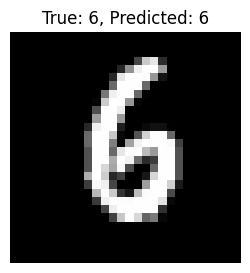

Example 2: True digit = 7, Predicted digit = 7


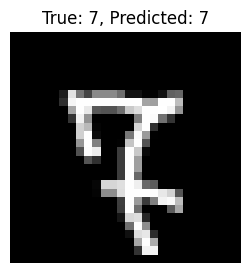

Example 3: True digit = 0, Predicted digit = 0


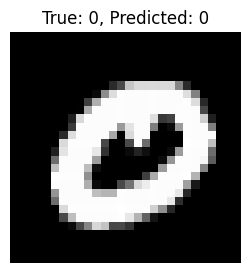

In [21]:
# Load the MNIST data
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

# Import necessary modules
import matplotlib.pyplot as plt
import numpy as np

# Assuming the Network class is already defined in a previous cell in this notebook,
# no need to import it from a separate file. If it's not defined yet, paste the full
# Network class code (including save/load methods) into a cell above this one and run it.

# Load the trained model
loaded_net = Network.load("trained_digit_net.pkl")
print("Loaded trained model from 'trained_digit_net.pkl'")

def test_individual_predictions(network, test_data, num_examples=5):
    """Test the network on a few individual examples and show the images"""
    print("\nTesting individual predictions:")
    print("="*40)
    
    # Take a few random examples
    indices = np.random.choice(len(test_data), num_examples, replace=False)
    
    for i, idx in enumerate(indices):
        x, y = test_data[idx]
        prediction = np.argmax(network.feedforward(x))
        
        print(f"Example {i+1}: True digit = {y}, Predicted digit = {prediction}")
        
        # Display the image
        plt.figure(figsize=(3, 3))
        image = x.reshape(28, 28)
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {y}, Predicted: {prediction}")
        plt.axis('off')
        plt.show()

# Test the loaded network
test_individual_predictions(loaded_net, test_data, 3)

In [2]:
import pickle
import json

# Load pkl
with open('trained_digit_net.pkl', 'rb') as f:
    data = pickle.load(f)

# Convert to JSON-friendly (already lists, so no tolist needed)
json_data = {
    "sizes": data["sizes"],
    "weights": data["weights"],
    "biases": data["biases"]
}

# Save JSON
with open('trained_digit_net.json', 'w') as f:
    json.dump(json_data, f)